In [153]:
import os 

import pandas as pd
import numpy as np 

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer

from sklearn.decomposition import PCA


## Regression Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso 
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


## Classification Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from scipy.optimize import minimize

# I - Introduction 

This project is part of a "challenge data ens" : https://challengedata.ens.fr/participants/challenges/140/        
The goal of the project is to predict the difference between the vwap of the intraday prices and the spot prices. Therefore, we have a keen interest on two things : 
- the direction of the prediction : Is the intraday price higher than the spot ? 
- the magnitude of the difference : By how much is the intraday price higher than the spot ?
Therefore, the problem is a mix of a classification (specifying the direction) and a regression (the magnitude of the direction)

In [2]:
path_file_x_train = os.path.dirname(os.getcwd()) + "/datasets/elmy_spot_vs_intraday/X_train.csv"
path_file_y_train = os.path.dirname(os.getcwd()) + "/datasets/elmy_spot_vs_intraday/y_train.csv"

path_file_x_test =  os.path.dirname(os.getcwd()) + "/datasets/elmy_spot_vs_intraday/X_test.csv"

X_temp = pd.read_csv(path_file_x_train)
y_temp = pd.read_csv(path_file_y_train)
X_temp.set_index("DELIVERY_START", inplace = True)
y_temp.set_index("DELIVERY_START", inplace = True)
df = pd.concat([X_temp,y_temp], axis = 1)
df.sort_index(inplace = True)

In [3]:
df

,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price,spot_id_delta
DELIVERY_START,,,,,,,,,,
2022-01-01 02:00:00+01:00,49439.0,3386.0,11487.0,44118.0,3035.0,0.0,79.248348,0.000000,NaN,-36.874770
2022-01-01 03:00:00+01:00,46511.0,3386.0,11487.0,44118.0,3143.0,0.0,61.776532,0.000000,NaN,-12.643588
2022-01-01 04:00:00+01:00,45158.0,3386.0,11487.0,44118.0,3288.0,0.0,44.291112,0.000000,NaN,-1.950193
2022-01-01 05:00:00+01:00,44779.0,3386.0,11487.0,44118.0,3447.0,0.0,36.127588,0.000000,NaN,1.938272
2022-01-01 06:00:00+01:00,45284.0,3386.0,11487.0,44118.0,3679.0,0.0,30.983023,0.000000,NaN,0.199907
...,...,...,...,...,...,...,...,...,...,...
2023-03-29 19:00:00+02:00,50814.0,3386.0,11952.0,38320.0,7552.0,651.0,247.408490,7.821622,108.11,6.029303
2023-03-29 20:00:00+02:00,50628.0,3386.0,11952.0,38320.0,8338.0,109.0,155.795012,2.534054,125.66,13.576177
2023-03-29 21:00:00+02:00,48201.0,3386.0,11952.0,38320.0,9115.0,0.0,126.884684,0.000000,138.01,17.478945


In [5]:
print(f"number of rows : {df.shape[0]}")
print(f"number of columns : {df.shape[1]}")

number of rows : 10605
number of columns : 10


# II - Exploratory Data Analysis 

## II.1) Basic Stuff

In [6]:
df.head(10)

,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price,spot_id_delta
DELIVERY_START,,,,,,,,,,
2022-01-01 02:00:00+01:00,49439.0,3386.0,11487.0,44118.0,3035.0,0.0,79.248348,0.000000,NaN,-36.874770
2022-01-01 03:00:00+01:00,46511.0,3386.0,11487.0,44118.0,3143.0,0.0,61.776532,0.000000,NaN,-12.643588
2022-01-01 04:00:00+01:00,45158.0,3386.0,11487.0,44118.0,3288.0,0.0,44.291112,0.000000,NaN,-1.950193
2022-01-01 05:00:00+01:00,44779.0,3386.0,11487.0,44118.0,3447.0,0.0,36.127588,0.000000,NaN,1.938272
2022-01-01 06:00:00+01:00,45284.0,3386.0,11487.0,44118.0,3679.0,0.0,30.983023,0.000000,NaN,0.199907
2022-01-01 07:00:00+01:00,45648.0,3386.0,11487.0,44118.0,3902.0,0.0,27.624052,0.000000,NaN,-0.943992
2022-01-01 08:00:00+01:00,45909.0,3386.0,11487.0,44118.0,4092.0,198.0,44.944701,6.195349,NaN,-2.770881
2022-01-01 09:00:00+01:00,47091.0,3386.0,11487.0,44118.0,4315.0,1012.0,30.505330,23.239957,NaN,-17.576596
2022-01-01 10:00:00+01:00,48300.0,3386.0,11487.0,44118.0,4436.0,2401.0,35.835910,44.450154,NaN,-12.352031


In [7]:
print(f"The dataset has : \n -{df.shape[0]} rows \n -{df.shape[1]} columns")

The dataset has : 
 -10605 rows 
 -10 columns


There seems to be few features for an interesting number of data

In [6]:
print("The columns are the following : ")
print(df.columns.tolist())

The columns are the following : 
['load_forecast', 'coal_power_available', 'gas_power_available', 'nucelear_power_available', 'wind_power_forecasts_average', 'solar_power_forecasts_average', 'wind_power_forecasts_std', 'solar_power_forecasts_std', 'predicted_spot_price', 'spot_id_delta']


In [7]:
for col_type in df.dtypes.value_counts().index:
    print("Column type:", col_type)
    print(df.select_dtypes(col_type).columns.tolist())
    print("--------------------------------------------------------------------------------------")

Column type: float64
['load_forecast', 'coal_power_available', 'gas_power_available', 'nucelear_power_available', 'wind_power_forecasts_average', 'solar_power_forecasts_average', 'wind_power_forecasts_std', 'solar_power_forecasts_std', 'predicted_spot_price', 'spot_id_delta']
--------------------------------------------------------------------------------------


All our data are numbers. Therefore, they can right now be used to work on our models. However, if we somehow want to transform our index (DELIVERY_START) as a feature, we might have to change some stuff

## II.2) Missing Values

In [8]:
(df.isna().sum(axis = 0)/df.shape[0] * 100).sort_values(ascending = False)

predicted_spot_price             82.593116
load_forecast                    12.135785
wind_power_forecasts_average      0.226308
solar_power_forecasts_average     0.226308
wind_power_forecasts_std          0.226308
solar_power_forecasts_std         0.226308
coal_power_available              0.009430
gas_power_available               0.009430
nucelear_power_available          0.009430
spot_id_delta                     0.000000
dtype: float64

<Axes: >

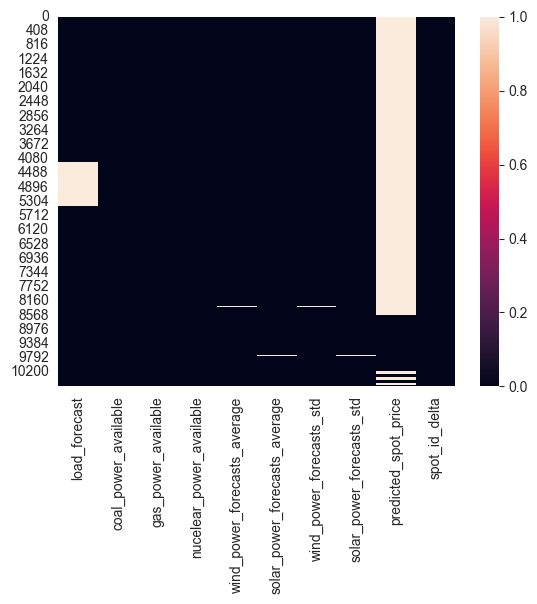

In [10]:
sns.heatmap(df.isna().reset_index(drop = True), cbar = True)

The distribution of the missing values is quite surprising : 
- the predicted spot price is missing from nearly all rows 
- the load forecast is missing for a specific period
- Other missing values are in little numbers and could be due to *little* issues with data

Handling the missing values doesn't seem so straightforward as if we thought about dropping : 
- the column predicted_spot_price as it's mostly missing
- the rows of missing wind, coal, nuclear etc. as there is few missing values      

The question of what to do with the load forecast is still present as we are in the in-between

In [11]:
df_temp = df.copy(deep = True)
df_temp.drop("predicted_spot_price", axis = 1, inplace = True)
df_temp.dropna(inplace = True)
print(f"before dropping rows : {df.shape[0]}")
print(f"after dropping rows : {df_temp.dropna(axis = 0).shape[0]}")
print(f"The remaining percentage of rows is : {round(df_temp.dropna(axis = 0).shape[0]/df.shape[0],3)}")

before dropping rows : 10605
after dropping rows : 9269
The remaining percentage of rows is : 0.874


## II.3) Relations between predictors and target variable

First of all remember that the problem mix a regression AND a classification. Therefore we are interested by numbers AND classes. We will thus add a variable "spot_id_delta_direction" which would give us the classes where :
- 1 means that the intraday price is superior to the spot price
- 0 Otherwise 

In [12]:
df["spot_id_delta_direction"] = np.where(df.spot_id_delta >= 0, 1, 0)
predictors_col = [col for col in df.columns if col not in ["spot_id_delta_direction", "spot_id_delta"]]

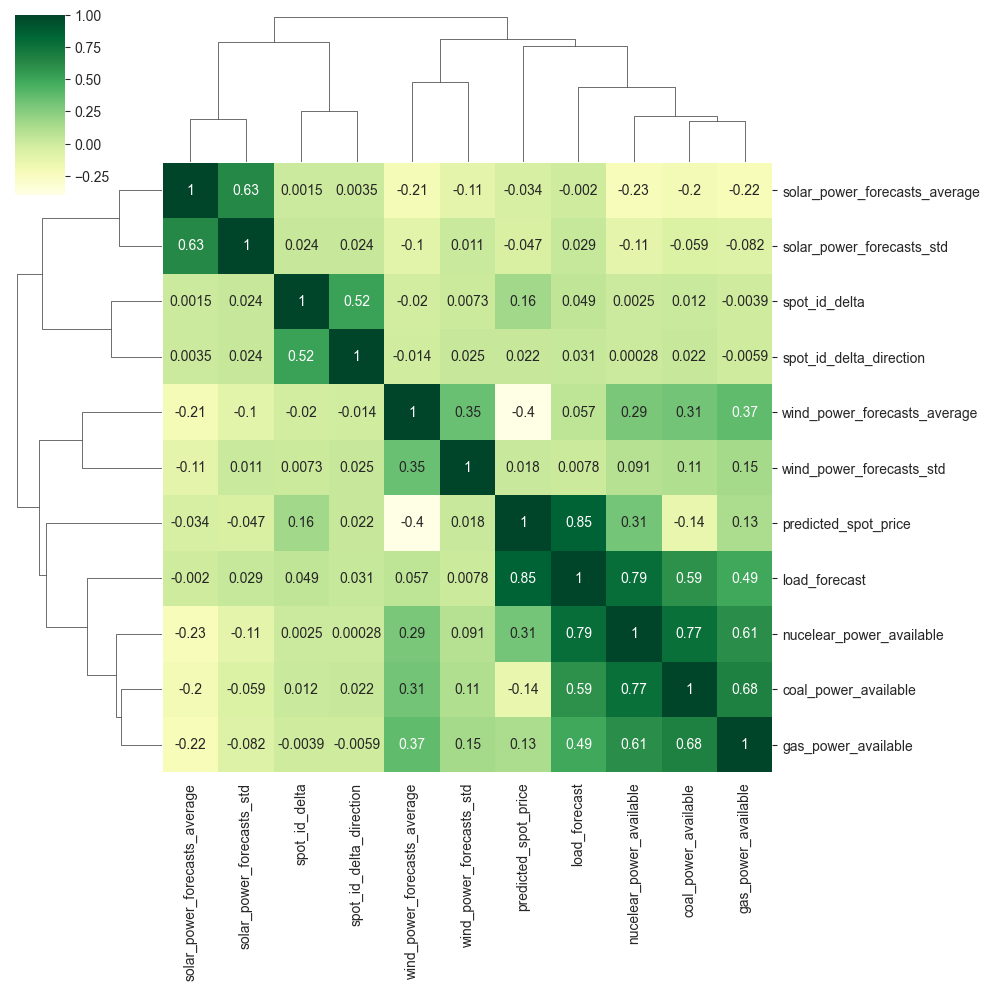

In [13]:
sns.clustermap(df.reset_index(drop = True).corr(), annot =True, cmap = "YlGn")

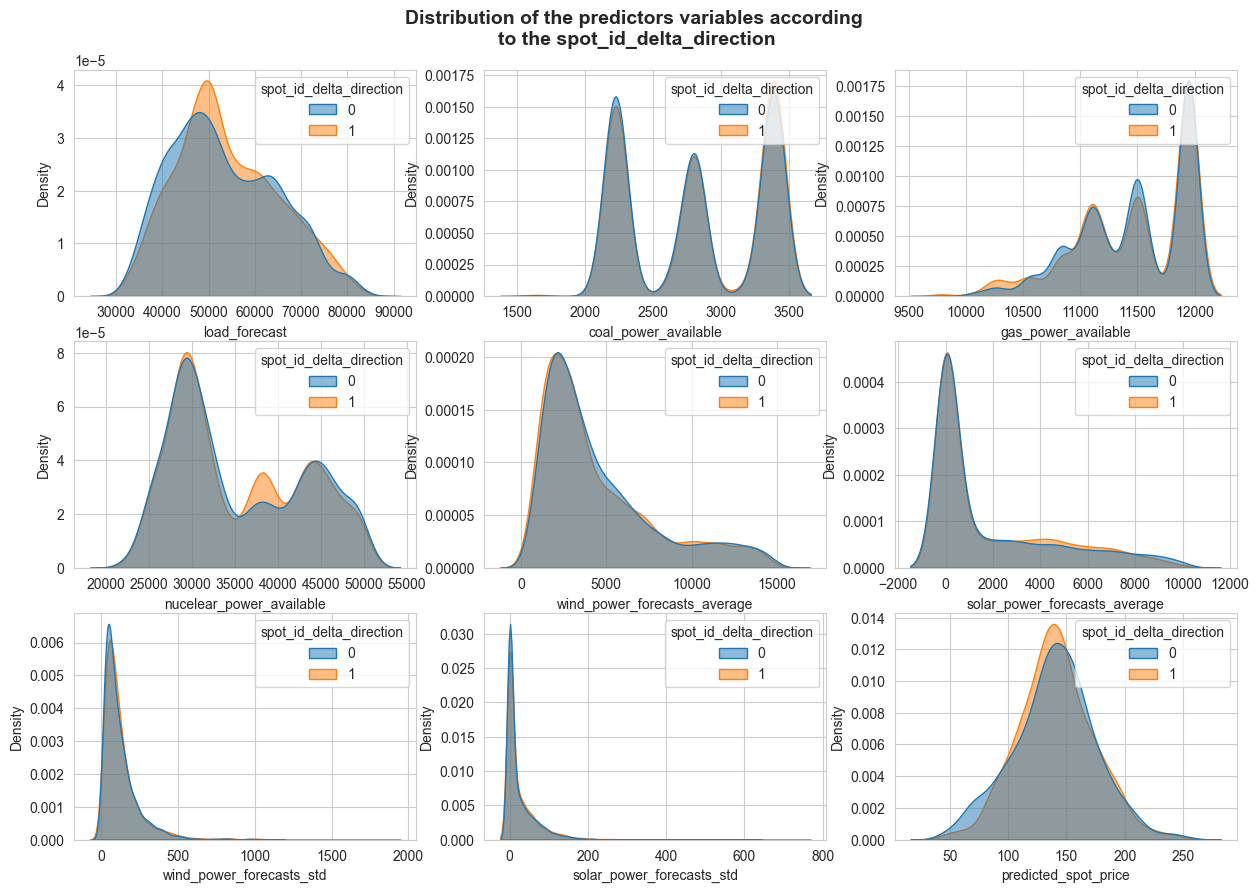

In [14]:
n_rows = 3 
n_cols = 3
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize = (15,10))
for k,col in enumerate(predictors_col):
    sns.kdeplot(
                data=df,
                x=col,
                hue="spot_id_delta_direction",
                fill=True, 
                common_norm=False,
                alpha=.5,
                linewidth=1,
                ax=axes[k//n_cols,k%n_cols]
    )
fig.suptitle("Distribution of the predictors variables according \nto the spot_id_delta_direction", y = 0.94, fontsize = 14, fontweight = 'bold')
plt.show()

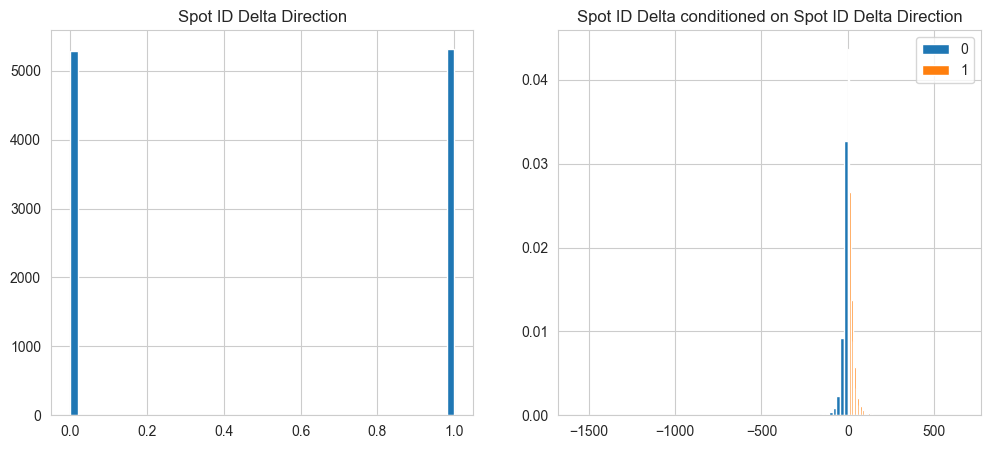

In [85]:
fig, axes = plt.subplots(nrows=1, ncols=2,  figsize = (12,5))
axes[0].hist(df.spot_id_delta_direction, bins = 50)
axes[1].hist(df[df.spot_id_delta_direction == 0].spot_id_delta, bins = int(np.sqrt(df[df.spot_id_delta_direction == 0].shape[0])), label = '0', density = True)
axes[1].hist(df[df.spot_id_delta_direction == 1].spot_id_delta, bins = int(np.sqrt(df[df.spot_id_delta_direction == 1].shape[0])), label = '1', density = True)
axes[0].set_title("Spot ID Delta Direction")
axes[1].set_title("Spot ID Delta conditioned on Spot ID Delta Direction")
plt.legend()
plt.show()

## II.4) Outliers in the target variable

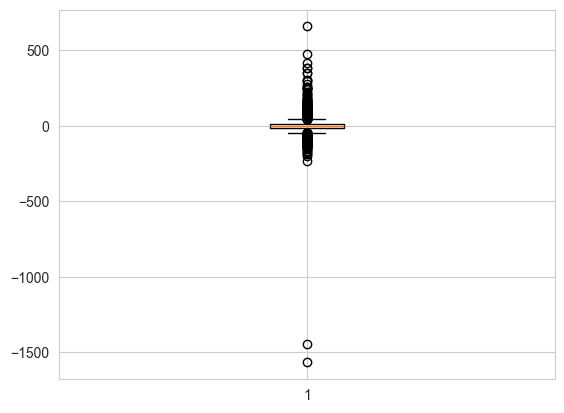

In [118]:
plt.boxplot(df.spot_id_delta)
plt.show()

In [95]:
sigma = df.spot_id_delta.std()
mu = df.spot_id_delta.mean()

df_outliers = df[(df.spot_id_delta >= (mu + 3*sigma)) | (df.spot_id_delta <= mu-3*sigma)]
df_no_outliers = df[~df.index.isin(df_outliers.index)]

In [119]:
print(f"mean of the distribution : {mu}")
print(f"standard deviation of the distribution : {sigma}")

mean of the distribution : 0.9433581668879992
standard deviation of the distribution : 38.09381853659664


In [102]:
print(f"size of the sample : {df.shape[0]}")
print(f"number of outliers : {df_outliers.shape[0]}")
print(f"percentage of outliers : {df_outliers.shape[0]/df.shape[0] * 100}")

size of the sample : 10605
number of outliers : 113
percentage of outliers : 1.0655351249410656


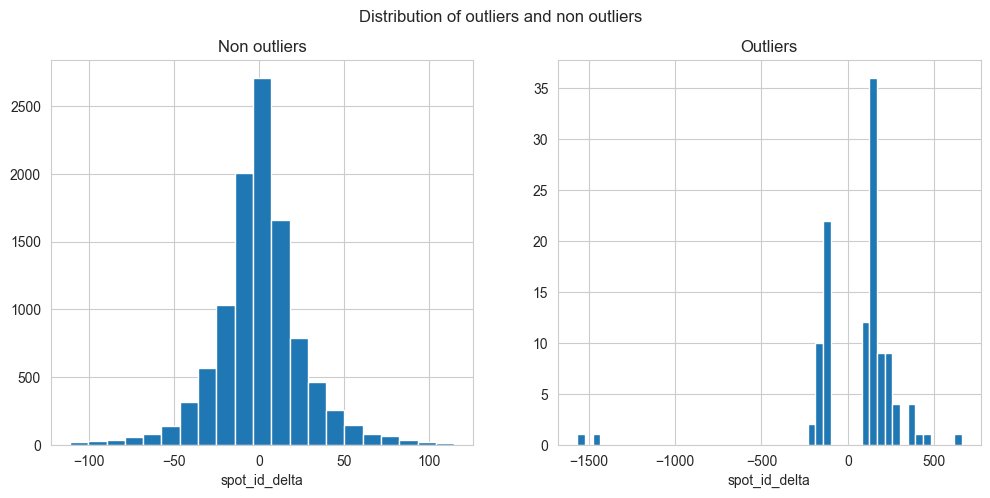

In [116]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (12,5))

fig.suptitle("Distribution of outliers and non outliers")
ax[0].hist(df_no_outliers.spot_id_delta, bins = int(df_no_outliers.shape[0]**(1/3)) )
ax[1].hist(df_outliers.spot_id_delta, bins = 50 )
ax[0].set_xlabel("spot_id_delta"); ax[1].set_xlabel("spot_id_delta")
ax[0].set_title("Non outliers"); ax[1].set_title("Outliers")
plt.show()

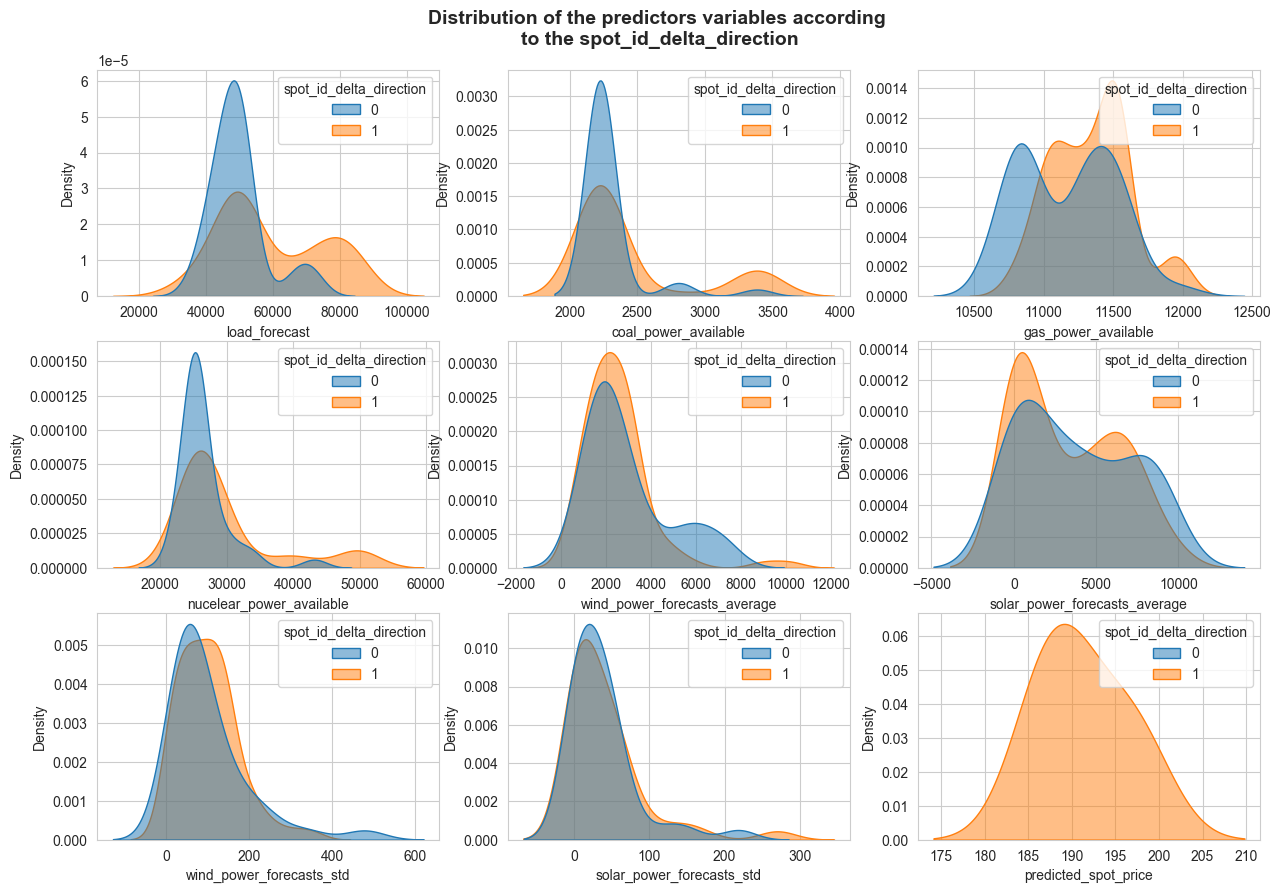

In [122]:
n_rows = 3 
n_cols = 3
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize = (15,10))
for k,col in enumerate(predictors_col):
    sns.kdeplot(
                data=df_outliers,
                x=col,
                hue="spot_id_delta_direction",
                fill=True, 
                common_norm=False,
                alpha=.5,
                linewidth=1,
                ax=axes[k//n_cols,k%n_cols]
    )
fig.suptitle("Distribution of the predictors variables according \nto the spot_id_delta_direction", y = 0.94, fontsize = 14, fontweight = 'bold')
plt.show()

Some interesting thoughts : 
- The classes are balanced therefore no issue with unbalanced data 
- Looking at the predictors conditioned on the classe of the target variable doesn't give more insight about the classe of the target variable
- There are some outliers in our target variable, if we don't take them into account the target variable can be taken as a gaussian but those outliers add fat tails. Taking them into account at least in our understanding of the problem is necessary

Can we get some new information with clustering techniques such as a PCA ?

## II.5) Information through clustering 

In [123]:
pca_2 = PCA(n_components=2,svd_solver='full')
X = df[predictors_col].dropna()
y_temp = df.loc[X.index, "spot_id_delta_direction"]

sc = StandardScaler()
sc.fit(X)
X_pca = pca_2.fit_transform(sc.transform(X))

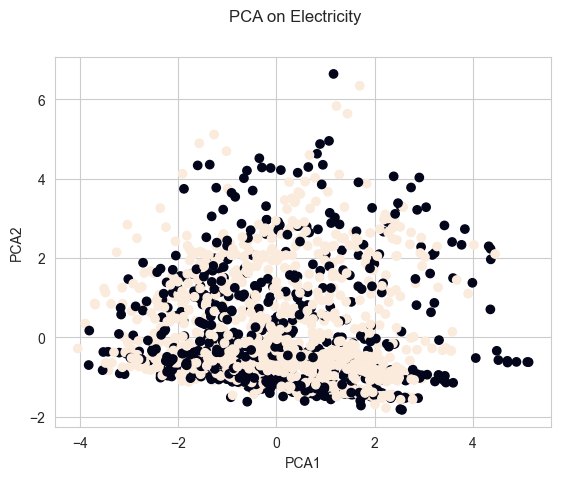

In [124]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_temp)
plt.suptitle("PCA on Electricity")
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.show()

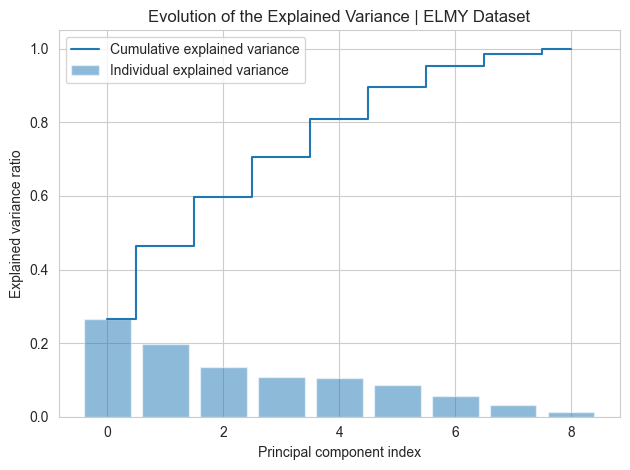

In [125]:
pca = PCA(svd_solver='full')
sc = StandardScaler()

sc.fit(X)
X_pca = pca.fit_transform(sc.transform(X))

exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.title("Evolution of the Explained Variance | ELMY Dataset")
plt.tight_layout()
plt.show()

In [126]:
pd.DataFrame(pca.components_,columns=X.columns, index = [f"PCA{k}" for k in range(len(X.columns))])

,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std,predicted_spot_price
PCA0,-0.575706,0.216263,-0.153397,-0.357562,0.361766,0.024473,0.085959,0.058348,-0.572839
PCA1,0.120844,0.084359,-0.078915,-0.204098,-0.165478,0.677940,-0.079932,0.659948,0.038612
PCA2,0.108445,0.173618,0.397774,0.228293,0.416077,0.054601,0.720426,0.205664,0.101694
PCA3,0.244815,0.160451,-0.757126,-0.289293,0.046414,-0.127874,0.398376,-0.070144,0.274339
PCA4,0.017399,-0.865846,-0.254530,0.161442,0.325383,0.117731,0.088225,0.106647,-0.142358
PCA5,0.101376,0.370093,-0.349185,0.650782,0.399278,0.095552,-0.362112,0.055676,-0.067297
PCA6,-0.274574,0.008073,-0.219737,0.481700,-0.627776,-0.062580,0.376104,0.141404,-0.291130
PCA7,-0.027991,-0.031933,0.005522,-0.048150,0.054260,-0.690620,-0.165947,0.692371,0.095035
PCA8,0.703925,0.049820,0.061217,-0.103688,-0.064221,-0.128849,0.024561,-0.000830,-0.682773


It seems that the dimension of the problem can't be reduced as : 
- no PCA components explains by itself enough of the information (for 90% of explained variance we would need 6 components whereas our initial problem as 9 predictors
- the PCA plot with two components doesn't give clear ideas on dimension reduction
Therefore we won't go further in this direction 

# III - Models

## III.1) Custom Metric 

Before working on our models, we need to remember that the scoring function for this specific problem is not usual. Indeed instead of a RMSE or accuracy, our custom metric is the following : 
$$
\begin{equation*}
    f \left( y_{true}, y_{pred} \right) = \frac{\sum_{j=1}^{N} 1_{sign(y_{true,j}) =  sign(y_{pred,j}) } |y_{true,j} | }{ \sum_{j=1}^{N} |y_{true,j}|}
\end{equation*}
$$

In [127]:
def custom_weighted_accuracy(y_true, y_pred):
    correct_direction = (np.sign(y_true) == np.sign(y_pred))
    return np.sum(correct_direction*np.abs(y_true), axis = 0)/np.sum(np.abs(y_true), axis = 0)

scorer_weighted_accuracy = make_scorer(custom_weighted_accuracy, response_method="predict", greater_is_better=True)

## II.2) Trying a bunch of models

To make our selection we are first going to try a bunch of regression models without fine-tuning them. Then we will select a subset of models (the ones with the best performance) then study them to increase their performances. 

In [128]:
y_test = df["spot_id_delta"]
y_naive = np.ones(y_test.shape[0])

naive_score = custom_weighted_accuracy(y_test, y_naive)
print(naive_score)

0.5240327077778565


If we play the very naive model which always buy on the Day Ahead auction, we get a weighted accuracy of 0.52, this is therefore our reference point.


In [129]:
dic_regression_models = {
    "Linear Regression" : LinearRegression(),
    "Ridge Linear Regression" : Ridge(),
    "Lasso Linear Regression" : Lasso(),
    "Elastic Net Regression" : ElasticNet(),
    "Decision Tree Regressor" : DecisionTreeRegressor(),
    "KNN Regressor" : KNeighborsRegressor(),
    "Support Vector Regression" : SVR(),
    "Random Forest Regressor" : RandomForestRegressor(),
    "Xgboost Regressor" : XGBRegressor(),
    "Catboost Regressor" : CatBoostRegressor(allow_writing_files=False, logging_level = 'Silent')
}

In [130]:
df_temp = df.copy(deep = True)
X = df_temp[predictors_col].copy(deep = True)
X.drop("predicted_spot_price", axis = 1, inplace = True)
X.dropna(inplace = True)

y_regression = df_temp.loc[X.index,"spot_id_delta"]
y_classification = df_temp.loc[X.index,"spot_id_delta_direction"]

col_X = X.columns.tolist()
sc = StandardScaler()

X = pd.DataFrame(sc.fit_transform(X), columns = col_X)

In [131]:
dic_model_regression_scores = {}
for model_name,model in dic_regression_models.items():
    dic_model_regression_scores[model_name] = np.mean(cross_val_score(model, X, y_regression, cv=5, scoring=scorer_weighted_accuracy))

In [132]:
dic_model_regression_scores

{'Linear Regression': 0.5120267428619012,
 'Ridge Linear Regression': 0.5119791874910513,
 'Lasso Linear Regression': 0.4604440235005251,
 'Elastic Net Regression': 0.4663713532417987,
 'Decision Tree Regressor': 0.4857404388160787,
 'KNN Regressor': 0.5100716965598265,
 'Support Vector Regression': 0.4642966581000259,
 'Random Forest Regressor': 0.4999897347747323,
 'Xgboost Regressor': 0.5205073021758133,
 'Catboost Regressor': 0.49513073319034595}

In [133]:
df_score_regression = pd.DataFrame(dic_model_regression_scores, index = ["weighted_accuracy"]).T

In [134]:
df_score_regression.sort_values(by = "weighted_accuracy", ascending = False)

,weighted_accuracy
Xgboost Regressor,0.520507
Linear Regression,0.512027
Ridge Linear Regression,0.511979
KNN Regressor,0.510072
Random Forest Regressor,0.499990
Catboost Regressor,0.495131
Decision Tree Regressor,0.485740
Elastic Net Regression,0.466371
Support Vector Regression,0.464297
Lasso Linear Regression,0.460444


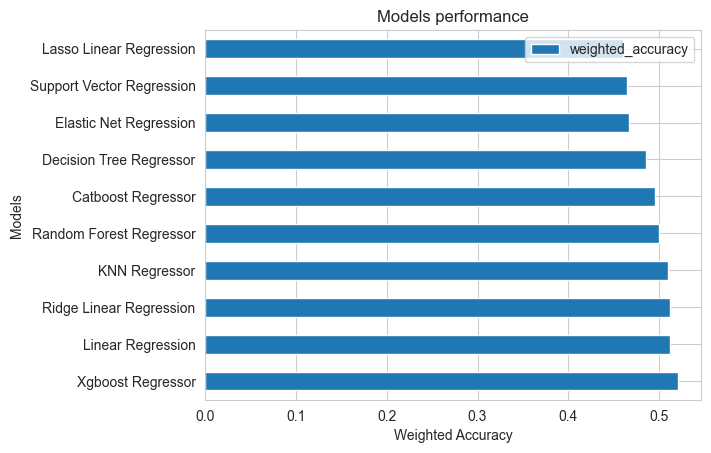

In [135]:
df_score_regression.sort_values(by = "weighted_accuracy", ascending = False).plot.barh()
plt.xlabel("Weighted Accuracy")
plt.ylabel("Models")
plt.title("Models performance")
plt.show()

What happens if we consider that our problem is a classification one ? 

In [136]:
dic_classification_models = {
    "Logistic Regression" : LogisticRegression(),
    "Support Vector Classifier" : SVC(),
    "Naive Bayes Classifier" : GaussianNB(),
    "Decision Tree Classifier" : DecisionTreeClassifier(),
    "KNN Classifier" : KNeighborsClassifier(),
    "Random Forest Classifier" : RandomForestClassifier(),
    "Xgboost Classifier" : XGBClassifier(),
    "Catboost Classifier" : CatBoostClassifier(allow_writing_files=False, logging_level = 'Silent')
}

In [137]:
dic_model_classifier_scores = {}
for model_name,model in dic_classification_models.items():
    dic_model_classifier_scores[model_name] = np.mean(cross_val_score(model, X, y_classification, cv=5, scoring=scorer_weighted_accuracy))

In [138]:
dic_model_classifier_scores

{'Logistic Regression': 0.49882854100106505,
 'Support Vector Classifier': 0.47199148029818955,
 'Naive Bayes Classifier': 0.3916932907348243,
 'Decision Tree Classifier': 0.42662406815761444,
 'KNN Classifier': 0.47838125665601705,
 'Random Forest Classifier': 0.4596379126730564,
 'Xgboost Classifier': 0.443237486687966,
 'Catboost Classifier': 0.4798722044728434}

In [139]:
df_score_classifier = pd.DataFrame(dic_model_classifier_scores, index = ["weighted_accuracy"]).T

In [140]:
df_score_classifier

,weighted_accuracy
Logistic Regression,0.498829
Support Vector Classifier,0.471991
Naive Bayes Classifier,0.391693
Decision Tree Classifier,0.426624
KNN Classifier,0.478381
Random Forest Classifier,0.459638
Xgboost Classifier,0.443237
Catboost Classifier,0.479872


## II.3) Fine-tuning models

For the sake of simplicity, we are going to save all our raw datas here 

In [165]:
X_train_raw = pd.read_csv(path_file_x_train)
y_train_raw = pd.read_csv(path_file_y_train)
y_train_raw_dates = y_train_raw.DELIVERY_START
y_train_raw.drop("DELIVERY_START", axis = 1, inplace = True)
X_test_raw = pd.read_csv(path_file_x_test)

### II.3.1) Linear Regression

The first model we want to try is the linear regression. Indeed, being the simplest model in terms of machine learning make it a nice first step to try different things However we must note that has it's a linear model, it doesn't acccept missing values, thus we will have to find a way to deal with it. We will first try the model on a dataset without missing value (by dropping them) then we will try different methods to fill the missing values 

For the following work, we are going to make our own pipeline to do the preprocessing. Supposing that we got our raw data we are going to :  
- put the DELIVERY_START column in index 
- drop the predicted_spot_price column 
- impute with the mean the missing data of each column 
- use a standard scaling on each feature
This approach is not elegant, but it's a starting point

In [143]:
class CustomPreprocess(BaseEstimator, TransformerMixin):
    
    def fit(self,X,y = None):
        return self
    
    def transform(self,X,y = None):
        if "DELIVERY_START" in X.columns:
            X.set_index("DELIVERY_START", inplace = True)
        return X
        

class CustomDrop(BaseEstimator,TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_temp = X.copy(deep = True)
        X_temp.drop(["predicted_spot_price"], axis = 1, inplace = True)
        
        return X_temp
    
class CustomImputer(BaseEstimator,TransformerMixin):
    
    def fit(self, X, y=None):
        self.imputer = SimpleImputer(missing_values=np.NaN, strategy='mean')
        self.imputer.fit(X)
        return self
    
    def transform(self, X, y=None):
        col_X = X.columns.tolist()
        index_X = X.index.tolist()
        df = pd.DataFrame(self.imputer.transform(X), columns = col_X) 
        df.index = index_X
        return df
    
class CustomStandardScaler(BaseEstimator,TransformerMixin):
    
    def fit(self, X, y=None):
        self.standard_scaler = StandardScaler()
        self.standard_scaler.fit(X)
        
        return self
    
    def transform(self, X, y=None):
        col_X = X.columns.tolist()
        index_X = X.index.tolist()
        df = pd.DataFrame(self.standard_scaler.transform(X), columns = col_X) 
        df.index = index_X
        return df
    
preprocess_pipeline_linear_reg = Pipeline(
    steps = [
        ('delivery_preprocess', CustomPreprocess()),
        ('dropper', CustomDrop()),
        ('imputer', CustomImputer()),
        ('std_scaler', CustomStandardScaler())
     ]
)

def full_pipeline(prepros_pip: Pipeline, model):
    return Pipeline([
        ('preprocessing', prepros_pip),
        ('model', model)
    ])

In [144]:
preprocess_pipeline_linear_reg

Pipeline(steps=[('delivery_preprocess', CustomPreprocess()),
                ('dropper', CustomDrop()), ('imputer', CustomImputer()),
                ('std_scaler', CustomStandardScaler())])

In [145]:
pipeline_linear_reg = full_pipeline(preprocess_pipeline_linear_reg, LinearRegression())

cv_scores = cross_val_score(
    pipeline_linear_reg,
    X_train_raw,
    y_train_raw,
    cv=5,
    scoring=scorer_weighted_accuracy
)

In [146]:
print(f"Cross Validation Scores : \n{cv_scores}")
print(f"Average of Cross Validation Scores : {cv_scores.mean()}")

Cross Validation Scores : 
[0.48777341 0.39010791 0.52616097 0.56492206 0.53626768]
Average of Cross Validation Scores : 0.5010464064935826


In [147]:
X_train, X_test, y_train, y_test = train_test_split(X_train_raw, y_train_raw, test_size=0.33, random_state=42)

In [148]:
X_train_new = preprocess_pipeline_linear_reg.fit_transform(X_train, y_train)
X_test_new = preprocess_pipeline_linear_reg.transform(X_test)

In [149]:
X_test_new

,load_forecast,coal_power_available,gas_power_available,nucelear_power_available,wind_power_forecasts_average,solar_power_forecasts_average,wind_power_forecasts_std,solar_power_forecasts_std
2022-01-13 18:00:00+01:00,2.590149,1.146294,0.049898,1.798833,-0.579387,-0.708789,-0.130428,-0.573907
2022-10-22 11:00:00+02:00,-1.037927,-0.025252,0.035446,-0.803713,-0.597719,1.253652,-0.511013,1.631039
2023-02-17 19:00:00+01:00,0.432344,-0.025252,0.995503,1.229052,0.420437,-0.708789,-0.245702,-0.573907
2022-02-18 02:00:00+01:00,-0.047746,1.146294,1.009955,1.393336,0.764530,-0.708789,1.539330,-0.573907
2023-01-31 18:00:00+01:00,1.742207,-0.025252,0.995503,1.306246,-0.006599,-0.680422,2.217483,-0.454180
...,...,...,...,...,...,...,...,...
2022-05-12 18:00:00+02:00,-0.541369,-0.287840,-0.666531,-0.752250,-0.736859,0.373556,0.576985,1.357260
2022-11-17 12:00:00+01:00,0.149476,-0.025252,0.995503,-0.450469,2.351266,0.799790,-0.631490,0.002637
2023-01-18 23:00:00+01:00,1.414860,-0.025252,0.995503,1.518693,-0.121998,-0.708789,1.070990,-0.573907
2023-01-08 18:00:00+01:00,-0.079165,1.146294,0.995503,1.320761,1.865028,-0.708789,2.274034,-0.573907


In [150]:
model_to_fit = LinearRegression()
model_to_fit.fit(X_train_new,y_train)
y_pred_train_linear_reg = model_to_fit.predict(X_train_new)
y_pred_test_linear_reg = model_to_fit.predict(X_test_new)

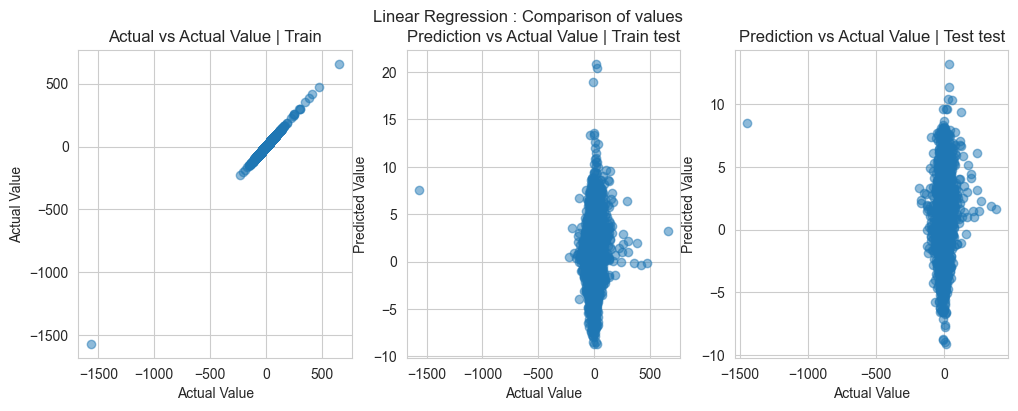

In [151]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (12,4))

ax[0].scatter(y_train, y_train, alpha = 0.5)
ax[1].scatter(y_train, y_pred_train_linear_reg, alpha = 0.5)
ax[2].scatter(y_test, y_pred_test_linear_reg, alpha = 0.5)


fig.suptitle('Linear Regression : Comparison of values')
ax[0].title.set_text("Actual vs Actual Value | Train")
ax[1].title.set_text("Prediction vs Actual Value | Train test")
ax[2].title.set_text("Prediction vs Actual Value | Test test")

ax[0].set_xlabel("Actual Value");ax[1].set_xlabel("Actual Value");ax[2].set_xlabel("Actual Value")
ax[0].set_ylabel("Actual Value"); ax[1].set_ylabel("Predicted Value"); ax[2].set_ylabel("Predicted Value")

plt.show()

In [194]:
y_pred_train_linear_reg

array([[ 0.86027758],
       [-0.00802739],
       [ 0.35308389],
       ...,
       [ 2.59950832],
       [-0.06284848],
       [-0.4124377 ]])

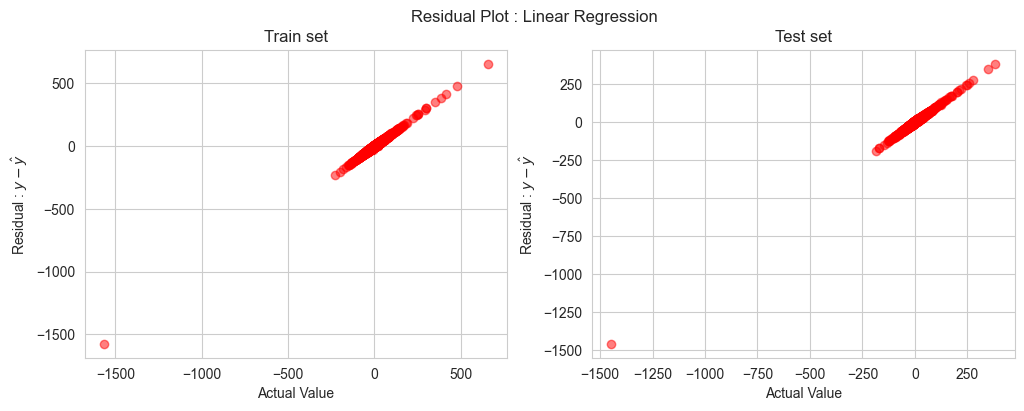

In [152]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12,4))

ax[0].scatter(y_train,  y_train - y_pred_train_linear_reg, alpha = 0.5, color = 'r')
ax[1].scatter(y_test, y_test - y_pred_test_linear_reg, alpha = 0.5, color = 'r')

fig.suptitle('Residual Plot : Linear Regression')
ax[0].title.set_text("Train set")
ax[1].title.set_text("Test set")
ax[0].set_xlabel("Actual Value");ax[1].set_xlabel("Actual Value")
ax[0].set_ylabel(r"Residual : $y - \hat{y}$");ax[1].set_ylabel(r"Residual : $y - \hat{y}$")
plt.show()

Due to the low results with a linear regression, we are not going to cover ridge, lasso, elastic regression and will go straightforward to the other models

### II.3.3) Decision Tree Regressor

For a decision tree we won't need to do some preprocessing. Indeed for our linear models we did some preprocessing because of : 
- assumption on the distribution : gaussian 
- handling missing values 
However a decision tree don't make any assumption on the distribution and can handle missing values. However what we will have to do is some true fine-tunning as we will have to find the optimal parameters

In [189]:
preprocess_pipeline_decision_tree = Pipeline(
    steps = [
        ('delivery_preprocess', CustomPreprocess()),
        ('dropper', CustomDrop()),
        ('imputer', CustomImputer()),
     ]
)

In [190]:
model_to_fit = DecisionTreeRegressor()
full_pipeline_tree = full_pipeline(preprocess_pipeline_decision_tree,model_to_fit)

In [191]:
dic_parameters = {
    "model__criterion" : ["squared_error", "friedman_mse", "absolute_error"],
    "model__max_depth" : [5, 10, 15,None],
    "model__min_samples_split" : [2,5,10],
    "model__max_features" : ["sqrt", "log2",None]
}

In [198]:
gridCV = GridSearchCV(
    estimator=full_pipeline_tree,
    scoring = scorer_weighted_accuracy,
    param_grid = dic_parameters,
    verbose=4
)

gridCV.fit(X_train_raw,y_train_raw.values.ravel())

Fitting 5 folds for each of 108 candidates, totalling 540 fits
[CV 1/5] END model__criterion=squared_error, model__max_depth=5, model__max_features=sqrt, model__min_samples_split=2;, score=0.449 total time=   0.0s
[CV 2/5] END model__criterion=squared_error, model__max_depth=5, model__max_features=sqrt, model__min_samples_split=2;, score=0.351 total time=   0.0s
[CV 3/5] END model__criterion=squared_error, model__max_depth=5, model__max_features=sqrt, model__min_samples_split=2;, score=0.487 total time=   0.0s
[CV 4/5] END model__criterion=squared_error, model__max_depth=5, model__max_features=sqrt, model__min_samples_split=2;, score=0.550 total time=   0.0s
[CV 5/5] END model__criterion=squared_error, model__max_depth=5, model__max_features=sqrt, model__min_samples_split=2;, score=0.682 total time=   0.0s
[CV 1/5] END model__criterion=squared_error, model__max_depth=5, model__max_features=sqrt, model__min_samples_split=5;, score=0.460 total time=   0.0s
[CV 2/5] END model__criterion=s

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        Pipeline(steps=[('delivery_preprocess',
                                                         CustomPreprocess()),
                                                        ('dropper',
                                                         CustomDrop()),
                                                        ('imputer',
                                                         CustomImputer())])),
                                       ('model', DecisionTreeRegressor())]),
             param_grid={'model__criterion': ['squared_error', 'friedman_mse',
                                              'absolute_error'],
                         'model__max_depth': [5, 10, 15, None],
                         'model__max_features': ['sqrt', 'log2', None],
                         'model__min_samples_split': [2, 5, 10]},
             scoring=make_scorer(custom_weighted_accuracy, response_method='predict'),
             verbose=4)

In [200]:
gridCV.best_params_

{'model__criterion': 'friedman_mse',
 'model__max_depth': 10,
 'model__max_features': 'log2',
 'model__min_samples_split': 5}

### II.3.4) KNN Regressor

### II.3.5) Xgboost Regressor

## II.4) Adding some feature engineering

Earlier we tried some model and looked at their performances etc. However, we tried it on the raw datas. But one of the aspect of machine learning is to work on the data to extract usefull information. This is called "Feature engineering" and it's the whole point of this subsection.

In [ ]:
print(df.columns.tolist())

In [ ]:
df_engineered = df.copy(deep = True)

df_engineered["delivery_hour_start"] = [pd.to_datetime(time).hour for time in df_engineered.index]

df_engineered["is_weekday"] = [1 if pd.to_datetime(val).dayofweek < 5 else 0 for val in df_engineered.index]
df_engineered["residual_load_forecast"] = df_engineered["load_forecast"] - (df_engineered['solar_power_forecasts_average'] + df_engineered["wind_power_forecasts_average"])

In [ ]:
df_engineered.delivery_hour_start

In [ ]:
df_engineered[["delivery_hour_start","residual_load_forecast","is_weekday"]]

In [ ]:
plt.hist(df_engineered["residual_load_forecast"], bins = 50, density = True)
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2,  figsize = (12,5),sharex=True, sharey=True)
axes[0].hist(df_engineered[df_engineered.is_weekday == 1]["load_forecast"], bins = int(np.sqrt(df_engineered[df_engineered.is_weekday == 1].shape[0])), density = True, label = "weekday", alpha = 0.8)
axes[0].hist(df_engineered[df_engineered.is_weekday == 0]["load_forecast"], bins = int(np.sqrt(df_engineered[df_engineered.is_weekday == 0].shape[0])), density = True, label = "weekend", alpha = 0.8)
axes[1].hist(df_engineered[df_engineered.is_weekday == 1]["residual_load_forecast"], bins = int(np.sqrt(df_engineered[df_engineered.is_weekday == 1].shape[0])), density = True, label = "weekday", alpha = 0.8)
axes[1].hist(df_engineered[df_engineered.is_weekday == 0]["residual_load_forecast"], bins =int(np.sqrt(df_engineered[df_engineered.is_weekday == 0].shape[0])), density = True, label = "weekend", alpha = 0.8)
axes[0].set_title("Load Forecast")
axes[1].set_title("Residual Load Forecast in France")
axes[0].set_xlabel("[MW]"); axes[1].set_xlabel("[MW]")
fig.suptitle("Load and Residual Load Forecast")
axes[0].legend() ; axes[1].legend()
plt.show()

In [ ]:
sns.clustermap(df_engineered.reset_index(drop = True).corr(), annot =True, cmap = "YlGn")
plt.show()

In [ ]:
df_engineered

In [ ]:
predictors_col_engineered = [col for col in df_engineered.columns if col not in ["spot_id_delta_direction", "spot_id_delta"]]
df_temp = df_engineered.copy(deep = True)

X = df_temp[predictors_col_engineered].copy(deep = True)
X.drop("predicted_spot_price", axis = 1, inplace = True)
X.dropna(inplace = True)

y_regression = df_temp.loc[X.index,"spot_id_delta"]
y_classification = df_temp.loc[X.index,"spot_id_delta_direction"]

col_X = X.columns.tolist()
sc = StandardScaler()

X = pd.DataFrame(sc.fit_transform(X), columns = col_X)

In [ ]:
pca = PCA(svd_solver='full')
sc = StandardScaler()

sc.fit(X)
X_pca = pca.fit_transform(sc.transform(X))

exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.title("Evolution of the Explained Variance | ELMY Dataset")
plt.tight_layout()
plt.show()

In [ ]:
pd.DataFrame(pca.components_,columns=X.columns, index = [f"PCA{k}" for k in range(len(X.columns))])

## II.4) Trying a bunch of models after feature engineering

In [ ]:
dic_model_regression_scores_engineered = {}
for model_name,model in dic_regression_models.items():
    dic_model_regression_scores_engineered[model_name] = np.mean(cross_val_score(model, X, y_regression, cv=5, scoring=custom_scorer))

In [ ]:
df_score_regression_engineered = pd.DataFrame(dic_model_regression_scores_engineered, index = ["weighted_accuracy_after_engineered"]).T

In [ ]:
pd.concat([df_score_regression,df_score_regression_engineered], axis = 1)